# Importation

In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import yaml

from pyoperators import (
    MPI,
    BlockRowOperator,
    DenseOperator,
    ReshapeOperator,
)
from pyoperators.iterative.core import AbnormalStopIteration
from pysimulators.interfaces.healpy import (
    HealpixConvolutionGaussianOperator,
    Spherical2HealpixOperator,
)

from qubic.lib.Instrument.Qacquisition import QubicDualBand
from qubic.lib.Instrument.Qinstrument import compute_freq
from qubic.lib.MapMaking.FrequencyMapMaking.Qspectra_component import CMBModel
from qubic.lib.MapMaking.Qatmosphere_2d import AtmosphereMaps
from qubic.lib.MapMaking.Qcg_test_for_atm import PCGAlgorithm
from qubic.lib.Qsamplings import QubicSampling, equ2gal, get_pointing

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline

In [2]:
# Import simulation parameters
with open("params.yml", "r") as file:
    params = yaml.safe_load(file)

np.random.seed(params["seed"])

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)
qubic_dict = atm.qubic_dict

npix = hp.nside2npix(params["nside"])

# Scanning Strategy

## Galactic Coordinates

In [4]:
### Random pointing
qubic_dict["random_pointing"] = True
qubic_dict['ate_obs'] = '2023-10-01 22:57:00.000'
qubic_dict['period'] = 3

### Sweepingpointing
qubic_dict["sweeping_pointing"] = False
qubic_dict["fix_azimuth"]["apply"] = False

# qubic_dict['angspeed'] = 0.4
# qubic_dict['delta_az'] = 20
# qubic_dict['nsweeps_per_elevation'] = 5
# qubic_dict['period'] = 1e-15
# qubic_dict['duration'] = 1
# npointings = 3600 * t_obs / period

### Repeat pointing
qubic_dict["repeat_pointing"] = False

qubic_dict["fix_azimuth"]["apply"] = False

q_sampling_gal = get_pointing(qubic_dict)
qubic_patch = np.array([0, -57])
center_gal = equ2gal(qubic_patch[0], qubic_patch[1])
center_local = np.array(
    [np.mean(q_sampling_gal.azimuth), np.mean(q_sampling_gal.elevation)]
) 
print(q_sampling_gal)

QubicSampling((10000,), 
    index=[   0    1    2 ... 9997 9998 9999],
    angle_hwp=[60 60 45 ... 60 60 45],
    azimuth=[215.69991503 202.97912581 220.77750822 ... 190.60994705 179.9108,
    elevation=[ 39.38626833  56.65489523  37.65596702 ...   7.62898669 -15.5301,
    equatorial=[[339.12721381 -56.35764262]
 [ 12.48898913 -53.50100626]
 [334.7,
    galactic=[[333.0263752  -52.15383358]
 [303.42799553 -63.62581628]
 [340.0,
    masked=False,
    pitch=[290.08873307 194.97146669 316.39923231 ... 152.80530101 349.2810)


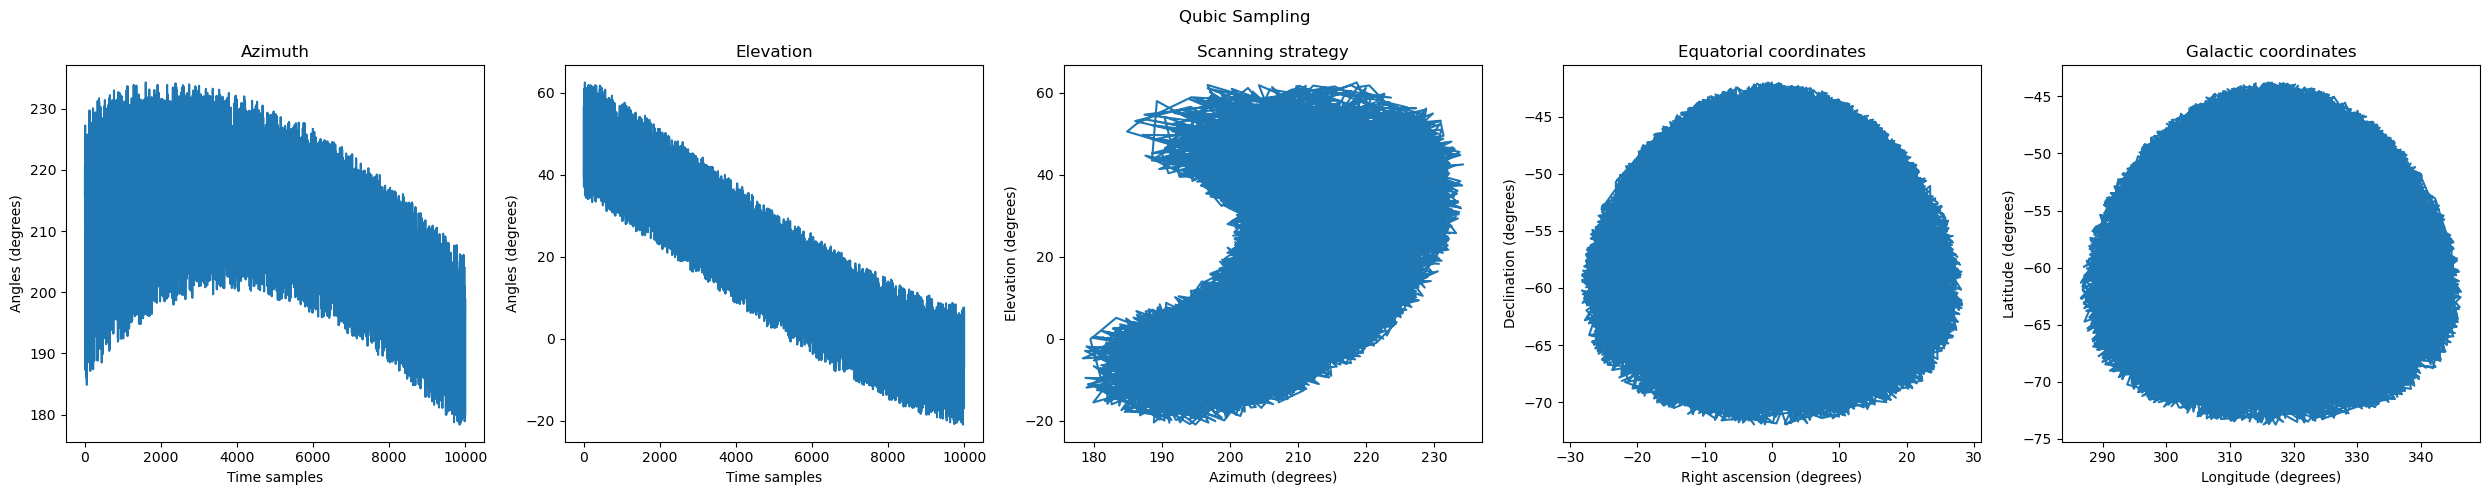

In [5]:
az, el = q_sampling_gal.azimuth, q_sampling_gal.elevation

fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# Azimuth plot
axs[0].plot(az)
axs[0].set_title("Azimuth")
axs[0].set_xlabel("Time samples")
axs[0].set_ylabel("Angles (degrees)")

# Elevation plot
axs[1].plot(el)
axs[1].set_title("Elevation")
axs[1].set_xlabel("Time samples")
axs[1].set_ylabel("Angles (degrees)")

# Scanning strategy plot
axs[2].plot(az, el)
axs[2].set_title("Scanning strategy")
axs[2].set_xlabel("Azimuth (degrees)")
axs[2].set_ylabel("Elevation (degrees)")

# Equatorial coordinates plot
axs[3].plot(
    (q_sampling_gal.equatorial[:, 0] + 180) % 360 - 180, q_sampling_gal.equatorial[:, 1]
)
axs[3].set_title("Equatorial coordinates")
axs[3].set_xlabel("Right ascension (degrees)")
axs[3].set_ylabel("Declination (degrees)")

# Galactic coordinates plot
axs[4].plot(q_sampling_gal.galactic[:, 0], q_sampling_gal.galactic[:, 1])
axs[4].set_title("Galactic coordinates")
axs[4].set_xlabel("Longitude (degrees)")
axs[4].set_ylabel("Latitude (degrees)")

fig.suptitle("Qubic Sampling")
plt.tight_layout()
plt.show()

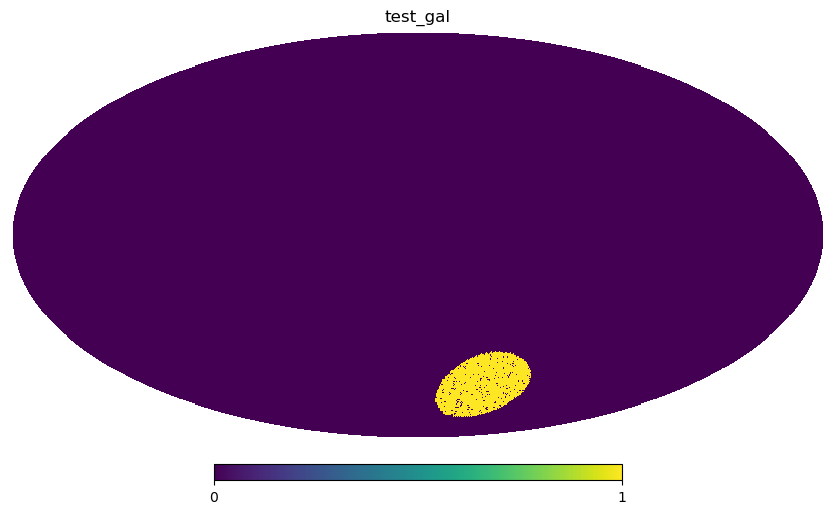

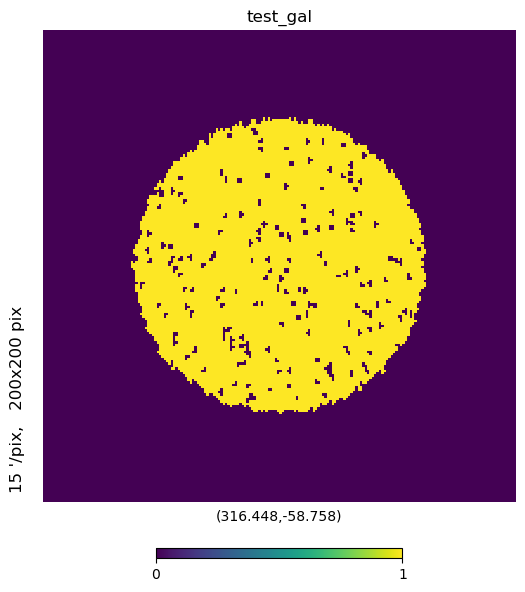

In [6]:
test_gal = np.zeros(hp.nside2npix(params["nside"]))

index = np.array(
    Spherical2HealpixOperator(params["nside"], "azimuth, elevation")(
        np.radians(q_sampling_gal.galactic)
    ),
    dtype="int",
)
test_gal[index] = 1
hp.mollview(test_gal, title="test_gal", cmap="viridis")
hp.gnomview(test_gal, title="test_gal", cmap="viridis", reso=15, rot=center_gal)

## Local Coordinates

In [7]:
q_sampling_local = QubicSampling(
    q_sampling_gal.index.size,  # int(np.ceil(qubic_dict['duration']*3600/qubic_dict['period'])),
    date_obs=qubic_dict["date_obs"],
    period=qubic_dict["period"],
    latitude=qubic_dict["latitude"],
    longitude=qubic_dict["longitude"],
)

q_sampling_local.azimuth = q_sampling_gal.azimuth
q_sampling_local.elevation = q_sampling_gal.elevation
q_sampling_local.pitch = q_sampling_gal.pitch
q_sampling_local.angle_hwp = q_sampling_gal.angle_hwp

q_sampling_local.fix_az = True

209.56537275811485 18.05774867975022


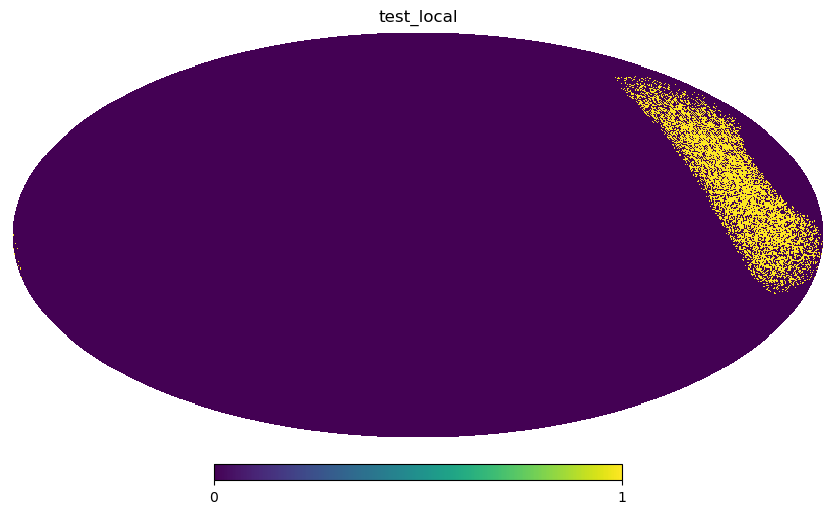

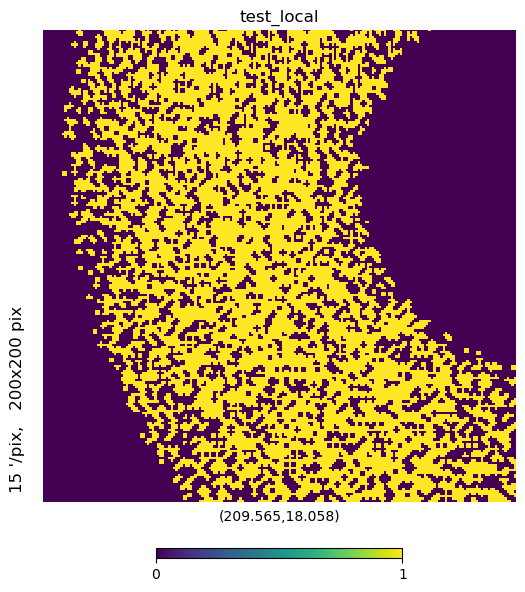

In [8]:
test_gal = np.zeros(hp.nside2npix(params["nside"]))

index = np.array(
    Spherical2HealpixOperator(params["nside"], "azimuth, elevation")(
        np.radians([q_sampling_local.azimuth, q_sampling_local.elevation]).T
    ),
    dtype="int",
)
test_gal[index] = 1
hp.mollview(test_gal, title="test_local", cmap="viridis")
hp.gnomview(
    test_gal,
    title="test_local",
    cmap="viridis",
    reso=15,
    rot=(np.mean(q_sampling_local.azimuth), np.mean(q_sampling_local.elevation)),
)

print(np.mean(q_sampling_local.azimuth), np.mean(q_sampling_local.elevation))

# Input Maps

## CMB

(6, 196608, 3)


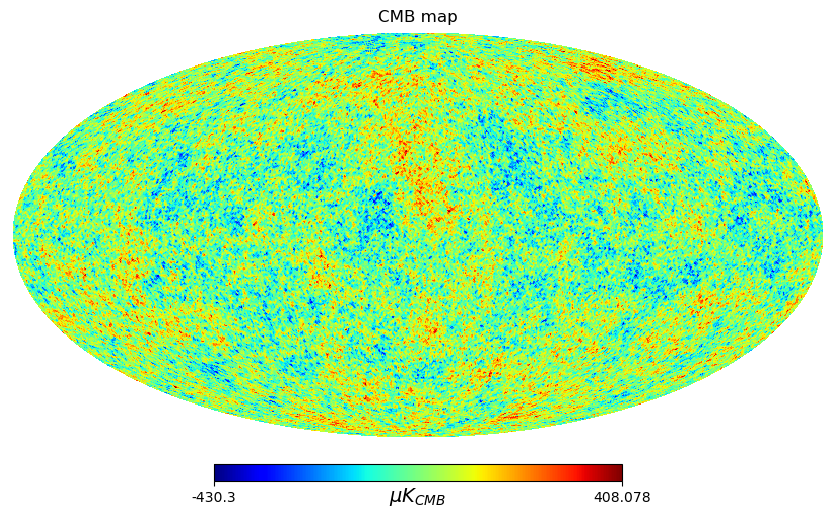

In [9]:
# Build CMB map
cl_cmb = CMBModel(None).give_cl_cmb(r=0, Alens=1)
cmb_map = hp.synfast(cl_cmb, params["nside"], new=True, verbose=False).T

cmb_maps = np.ones((params["nsub_in"], hp.nside2npix(params["nside"]), 3))
cmb_maps *= cmb_map[None]
print(cmb_maps.shape)

hp.mollview(cmb_map[:, 0], cmap="jet", title="CMB map", unit=r"$µK_{CMB}$")

## Atmosphere

In [10]:
atm_maps = np.zeros((cmb_maps.shape))

# mean_rho = atm.mean_water_vapor_density
# water_vapor_map = atm.get_water_vapor_density_fluctuation_2d_map(flat=False)
# for i in range(params["nsub_in"]):
#     atm_maps[i, :, 0] = water_vapor_map
atm_maps[..., 0] = atm.get_temp_maps(atm.delta_rho_map)

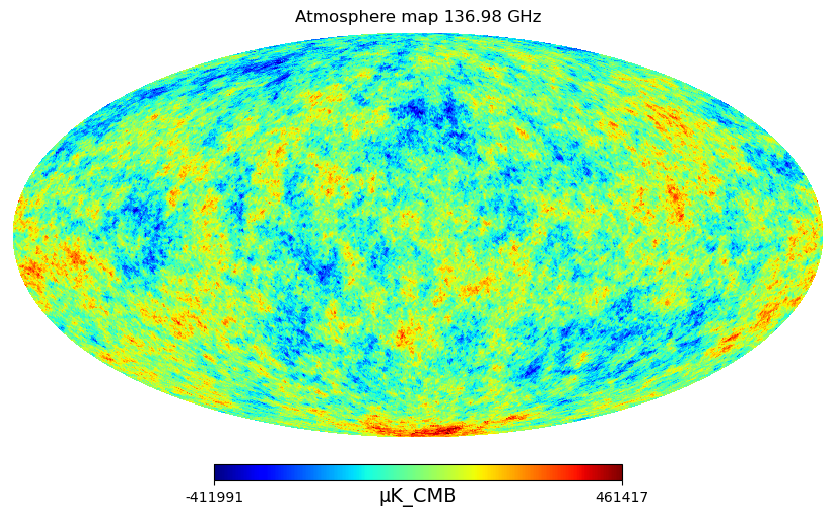

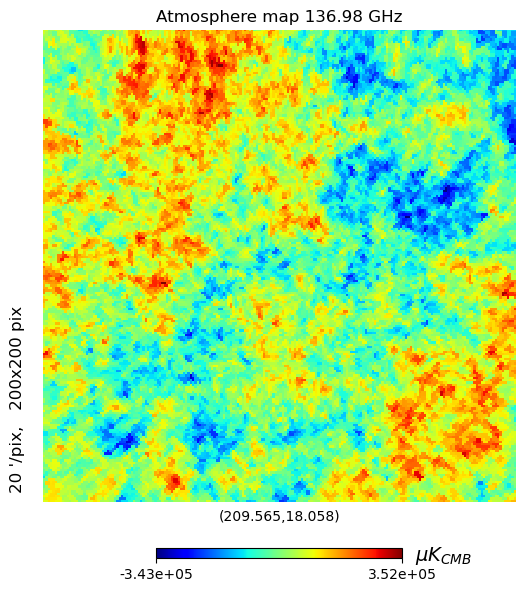

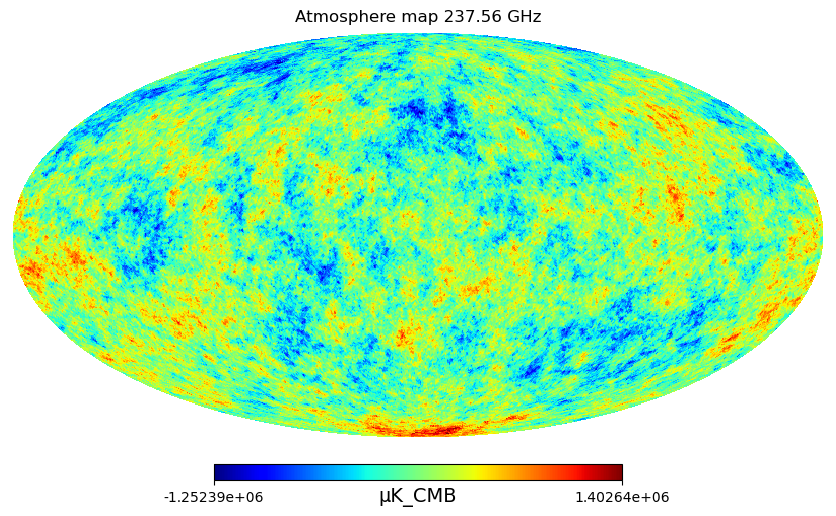

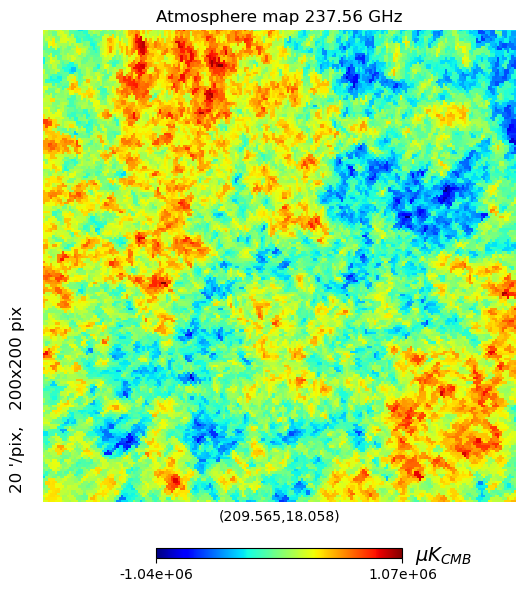

In [11]:
index_nu = 0
hp.mollview(
    atm_maps[index_nu, :, 0],
    cmap="jet",
    unit="µK_CMB",
    title="Atmosphere map {:.2f} GHz".format(atm.frequencies[index_nu]),
)
hp.gnomview(
    atm_maps[index_nu, :, 0],
    rot=center_local,
    reso=20,
    title="Atmosphere map {:.2f} GHz".format(atm.frequencies[index_nu]),
    unit=r"$µK_{CMB}$",
    cmap="jet",
)

index_nu = -1
hp.mollview(
    atm_maps[index_nu, :, 0],
    cmap="jet",
    unit="µK_CMB",
    title="Atmosphere map {:.2f} GHz".format(atm.frequencies[index_nu]),
)
hp.gnomview(
    atm_maps[index_nu, :, 0],
    rot=center_local,
    reso=20,
    title="Atmosphere map {:.2f} GHz".format(atm.frequencies[index_nu]),
    unit=r"$µK_{CMB}$",
    cmap="jet",
)

## Apply convolutions - Input Maps

In [12]:
fwhm_synthbeam150 = 0.006853589624526168

_, _, filter_nus150, deltas150, _, _ = compute_freq(
    150,
    int(params["nsub_in"] / 2),
    relative_bandwidth=qubic_dict["filter_relative_bandwidth"],
    frequency_spacing="log",
)
_, _, filter_nus220, deltas220, _, _ = compute_freq(
    220,
    int(params["nsub_in"] / 2),
    relative_bandwidth=qubic_dict["filter_relative_bandwidth"],
    frequency_spacing="log",
)

nus_tod = np.concatenate((filter_nus150, filter_nus220)) * 1e9
fwhm_tod = fwhm_synthbeam150 * 150e9 / nus_tod

In [13]:
for isub in range(nus_tod.size):
    C = HealpixConvolutionGaussianOperator(fwhm=fwhm_tod[isub])
    atm_maps[isub] = C(atm_maps[isub])
    cmb_maps[isub] = C(cmb_maps[isub])

## Input Maps

In [14]:
input_maps = np.zeros((2 * params["nsub_in"], hp.nside2npix(params["nside"]), 3))

input_maps[: params["nsub_in"]] = cmb_maps
input_maps[params["nsub_in"] :] = atm_maps

## True maps

In [15]:
### Build Expected Atm Maps
true_maps = np.zeros((2, 12 * params["nside"] ** 2, 3))

# Build the reconstructed maps and frequency by taking the mean inside each reconstructed frequency band
C = HealpixConvolutionGaussianOperator(fwhm=np.mean(fwhm_tod))
true_maps[0] = C(cmb_map)
true_maps[1] = C(np.mean(atm_maps, axis=0))

min_input = np.min(true_maps, axis=1)
max_input = np.max(true_maps, axis=1)

max = np.max([min_input, max_input], axis=0)
min_input = -max
max_input = max

# Mixing Matrix

In [16]:
MixingMatrix = np.ones((params["nsub_in"], 2))
# Atm mixing matrix
MixingMatrix[:, 1] = atm.temperature * atm.integrated_abs_spectrum * atm.mean_water_vapor_density

print(MixingMatrix.shape)
print(MixingMatrix[:, 1, None].shape)

(6, 2)
(6, 1)


# Build QUBIC Instances

In [17]:
q_acquisition_local = QubicDualBand(
    qubic_dict, params["nsub_in"], params["nsub_in"], sampling=q_sampling_local
)

q_acquisition_gal = QubicDualBand(
    qubic_dict, params["nsub_in"], params["nsub_in"], sampling=q_sampling_gal
)

Info DESKTOP-5T6UOML: Allocating (9920000,9) elements = 1.3303756713867188 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920000,9) elements = 1.3303756713867188 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920000,9) elements = 1.3303756713867188 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920000,9) elements = 1.3303756713867188 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920000,9) elements = 1.3303756713867188 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920000,9) elements = 1.3303756713867188 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920000,9) elements = 1.3303756713867188 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920000,9) elements = 1.3303756713867188 GiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (9920000,9) elements = 1.3303756713867188 GiB in FSRRotation3dMatrix.__

In [18]:
coverage_gal = q_acquisition_gal.coverage
covnorm_gal = coverage_gal / coverage_gal.max()
seenpix_gal = covnorm_gal > params["coverage_cut"]
seenpix_gal_wo_cut = covnorm_gal > 0

coverage_local = q_acquisition_local.coverage
covnorm_local = coverage_local / coverage_local.max()
seenpix_local = covnorm_local > params["coverage_cut"]
seenpix_local_wo_cut = covnorm_local > 0

seenpix = np.array([seenpix_gal, seenpix_local])

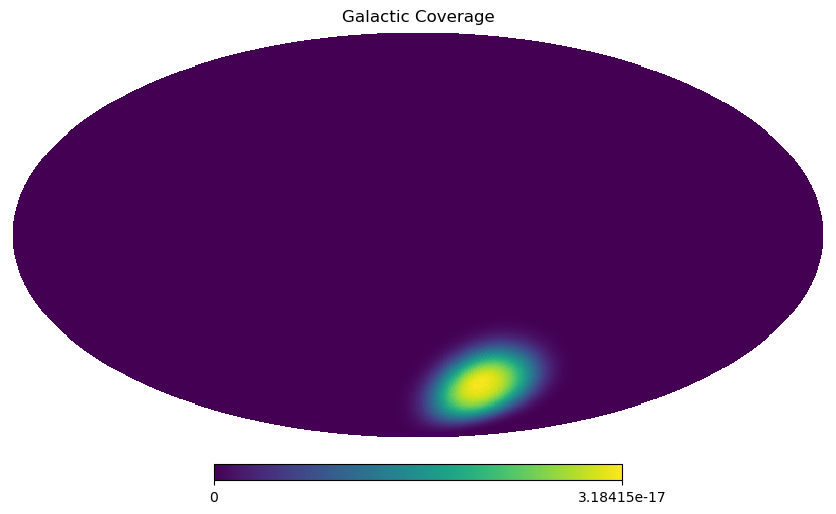

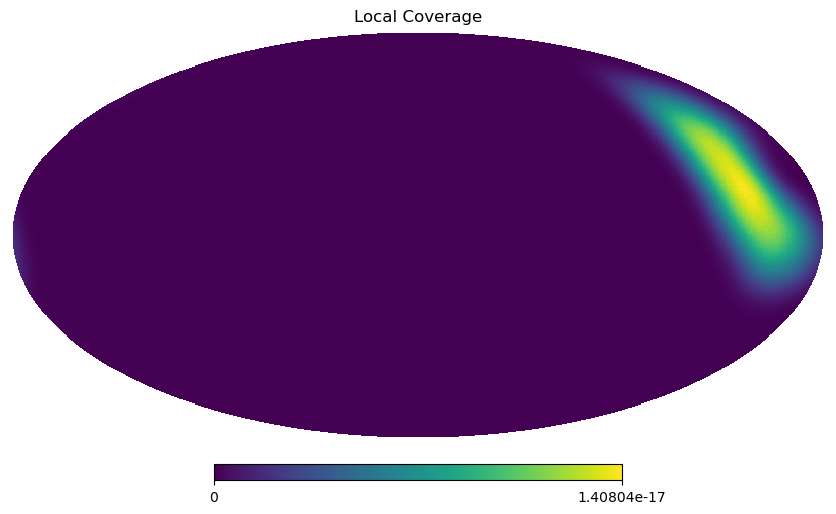

In [19]:
# Test coverage
hp.mollview(coverage_gal, title="Galactic Coverage")
hp.mollview(coverage_local, title="Local Coverage")

# Build QUBIC Operaotors

In [20]:
# Galactic Coordinates
H_gal = q_acquisition_gal.get_operator()

invN_gal = q_acquisition_gal.get_invntt_operator(False, False)

print("H_gal", H_gal.shapein, H_gal.shapeout)
print("invN_gal", invN_gal.shapein, invN_gal.shapeout)

H_gal (6, 196608, 3) (1984, 10000)
invN_gal (1984, 10000) (1984, 10000)


In [21]:
# Local Coordinates
H_local = q_acquisition_local.get_operator()

invN_local = q_acquisition_local.get_invntt_operator(False, False)

print("H_local", H_local.shapein, H_local.shapeout)
print("invN_local", invN_local.shapein, invN_local.shapeout)

H_local (6, 196608, 3) (1984, 10000)
invN_local (1984, 10000) (1984, 10000)


In [22]:
### Full MM
R = ReshapeOperator((2 * 992, params["npointings"]), (params["npointings"] * 992 * 2))

r = ReshapeOperator((npix, 3), (1, npix, 3))
A_gal = (
    DenseOperator(
        MixingMatrix[:, 0, None],
        broadcast="rightward",
        shapein=(1, npix, 3),
        shapeout=(params["nsub_in"], npix, 3),
    )
    * r
)
A_local = (
    DenseOperator(
        MixingMatrix[:, 1, None],
        broadcast="rightward",
        shapein=(1, npix, 3),
        shapeout=(params["nsub_in"], npix, 3),
    )
    * r
)

H_tod = BlockRowOperator([H_gal(A_gal), H_local(A_local)], axisin=0) * ReshapeOperator(
    (2, npix, 3), (2 * npix, 3)
)
print(H_tod.shapein, H_tod.shapeout)

H_rec = H_gal(A_local)
print(H_rec.shapein, H_rec.shapeout)

invN = invN_gal
print(invN.shapein, invN.shapeout)

tod = H_tod(true_maps)
print(tod.shape)

(2, 196608, 3) (1984, 10000)
(196608, 3) (1984, 10000)
(1984, 10000) (1984, 10000)
(1984, 10000)


In [23]:
print("H_tod", H_tod.shapein, H_tod.shapeout)
print("H_rec", H_rec.shapein, H_rec.shapeout)
print("invN", invN.shapein, invN.shapeout)
print("True maps", true_maps.shape)
print("tod", tod.shape)

H_tod (2, 196608, 3) (1984, 10000)
H_rec (196608, 3) (1984, 10000)
invN (1984, 10000) (1984, 10000)
True maps (2, 196608, 3)
tod (1984, 10000)


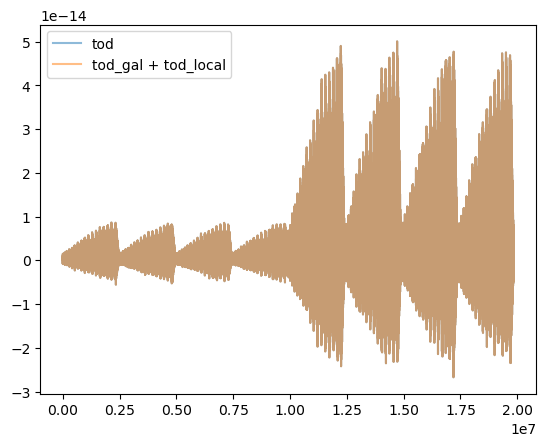

Difference between tod and tod_gal + tod_local :  []


In [24]:
### Test to verify if tod = tod_gal + tod_local

tod_gal = H_gal(A_gal(true_maps[0]))
tod_local = H_local(A_local(true_maps[1]))

plt.plot(tod.ravel(), label="tod", alpha=0.5)
plt.plot((tod_gal + tod_local).ravel(), label="tod_gal + tod_local", alpha=0.5)
plt.legend()
plt.show()

print(
    "Difference between tod and tod_gal + tod_local : ",
    np.setdiff1d(tod.ravel(), (tod_gal + tod_local).ravel()),
)

# Map-Making

In [25]:
# Ax=b equation to be solve by PCG
A = H_rec.T * invN * H_rec
b = H_rec.T * invN * tod

# I start from an atm map for the CMB and from a cmb map for the atmosphere
true_maps = true_maps[0]
x0 = true_maps.copy()
error_I = 2*np.std(x0[..., 0])
x0[..., 0] += np.random.uniform(-error_I, error_I, true_maps[..., 0].shape)

In [26]:
print("A", A.shapein, A.shapeout)
print("Ax", A(x0).shape)
print("b", b.shape)
print("true_maps", true_maps.shape)

A (196608, 3) (196608, 3)
Ax (196608, 3)
b (196608, 3)
true_maps (196608, 3)


In [27]:
# # Build Preconditionner
# no_det = 992

# stacked_dptdp_inv = np.zeros((true_maps.shape[0],12*params['nside']**2))
# stacked_dptdp_inv_nus = np.zeros((params["nsub_in"], npix))

# ### Loop on Maps
# for i_map in range(true_maps.shape[0]):
#     for j_fp in range(2):
#         for k_nu in range(int(params["nsub_in"]/2)):
#             print(k_nu + int(params['nsub_in']/2)*j_fp)
#             ### Extract Operators
#             h = H.operands[i_map].operands[0].operands[j_fp].operands[k_nu]
#             D = h.operands[1]
#             P = h.operands[-1]
#             sh = P.matrix.data.index.shape

#             ### Compute the map P^t P
#             point_per_det = int(sh[0] / no_det)
#             mapPtP_perdet_seq = np.zeros((no_det, 12 * params['nside']**2))
#             sample_ranges = [(det * point_per_det, (det + 1) * point_per_det) for det in range(no_det)]
#             for det, (start, end) in enumerate(sample_ranges):
#                 indices = P.matrix.data.index[start:end, :]
#                 weights = P.matrix.data.r11[start:end, :]
#                 flat_indices = indices.ravel()
#                 flat_weights = weights.ravel()

#                 mapPitPi = np.zeros(12 * params['nside']**2)
#                 np.add.at(mapPitPi, flat_indices, flat_weights**2)

#                 mapPtP_perdet_seq[det, :] = mapPitPi

#             D_elements = D.data
#             D_sq = D_elements**2
#             mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq
#             dptdp = mapPtP_seq_scaled.sum(axis = 0)
#             dptdp_inv = 1 / dptdp
#             dptdp_inv[np.isinf(dptdp_inv)] = 0.

#             stacked_dptdp_inv_nus[k_nu + int(params['nsub_in']/2)*j_fp] = dptdp_inv

#     stacked_dptdp_inv[i_map] = np.mean(stacked_dptdp_inv_nus, axis=0)

# M = BlockDiagonalOperator( \
#                     [DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv],
#                     new_axisin=0)

In [28]:
# Run PCG

seenpix_pcg = np.array([seenpix_gal, seenpix_local])

algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-8,
    maxiter=100,
    disp=True,
    M=None,
    center=[0, -57],
    reso=15,
    seenpix=seenpix_gal,
    input=true_maps,
)
try:
    result = algo.run()
    success = True
    message = "Success"
except AbnormalStopIteration as e:
    result = algo.finalize()
    success = False
    message = str(e)

 Iter     Tol      time
   1: 1.4091e-01 3.87666 [ 984.33298157 1007.08525647 1120.57109097 ... 4242.41928094 3814.26591859
 3663.58758041]
   2: 6.4202e-02 3.89820 [ 790.39912067  450.0191105   240.29539192 ... 7289.55101069 6356.9679632
 6016.63892021]
   3: 3.2686e-02 3.84232 [1636.98920741 1029.14200519  743.52700985 ... 8585.32572453 7076.52374659
 6669.5277392 ]
   4: 2.1487e-02 3.98262 [ 5955.26686306  5032.29980682  4818.34674502 ... 12095.8917413
  8631.3251908   8216.98138649]
   5: 1.7011e-02 4.05993 [ 8823.633658    7562.85989331  7507.85042615 ... 14275.08224661
  8613.57939981  8450.49697188]
   6: 1.6573e-02 3.86403 [10412.03843755  8683.86505717  8816.54709377 ... 16810.04711019
  8997.64157221  9290.58093798]
   7: 8.2188e-03 2.95875 [11542.90888717  9226.0706902   9527.3180098  ... 19203.41521111
  9358.46276132 10270.84370513]
   8: 6.5435e-03 3.79771 [14107.56350336 10460.00063189 11197.84000891 ... 24349.90095231
 10275.80626527 12807.60813931]
   9: 6.6087e-03 3.7

Text(0, 0.5, 'Convergence')

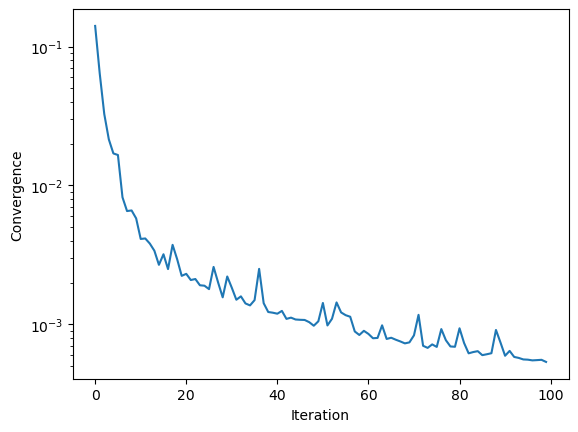

In [29]:
plt.plot(result["convergence"])
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Convergence")

In [30]:
input = true_maps.copy()
output = result["x"].copy()
residual = output - input

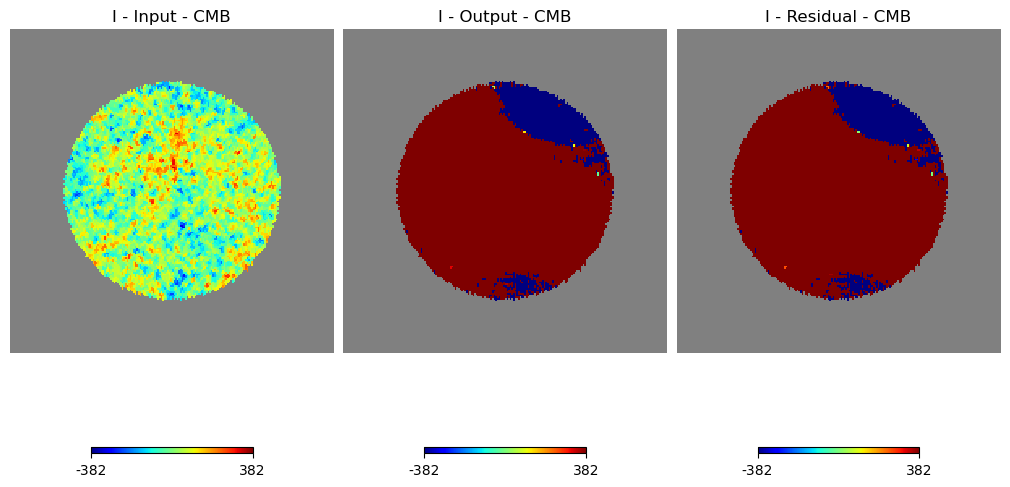

In [31]:
plt.figure(figsize=(10, 12))
k = 1

istk = 0
stk = ["I", "Q", "U"]

reso = 20

map = "CMB"
center = center_gal
input[~seenpix_gal, :] = hp.UNSEEN
output[~seenpix_gal, :] = hp.UNSEEN
residual[~seenpix_gal, :] = hp.UNSEEN


hp.gnomview(
    input[:, istk],
    reso=reso,
    rot=center_gal,
    min=min_input[0, istk],
    max=max_input[0, istk],
    cmap="jet",
    sub=(1, 3, k),
    title=f"{stk[istk]} - Input - {map}",
    notext=True,
)
hp.gnomview(
    output[:, istk],
    reso=reso,
    rot=center,
    min=min_input[0, istk],
    max=max_input[0, istk],
    cmap="jet",
    sub=(1, 3, k + 1),
    title=f"{stk[istk]} - Output - {map}",
    notext=True,
)
hp.gnomview(
    residual[:, istk],
    reso=reso,
    rot=center,
    min=min_input[0, istk],
    max=max_input[0, istk],
    cmap="jet",
    sub=(1, 3, k + 2),
    title=f"{stk[istk]} - Residual - {map}",
    notext=True,
)
k += 3

plt.tight_layout()

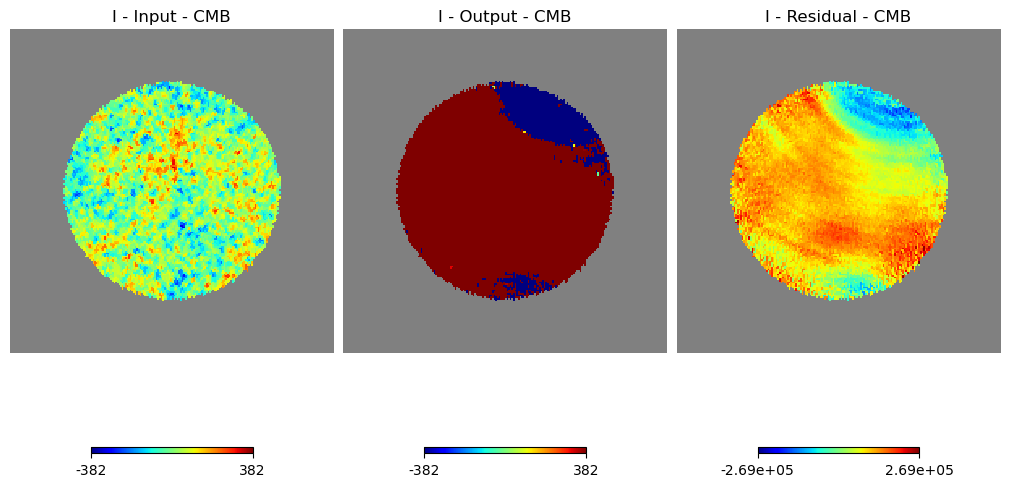

In [32]:
plt.figure(figsize=(10, 12))
k = 1

min_res = np.min(residual[seenpix_gal, istk])
max_res = np.max(residual[seenpix_gal, istk])
range_hp = np.max([-min_res, max_res])


hp.gnomview(
    input[:, istk],
    reso=reso,
    rot=center_gal,
    min=min_input[0, istk],
    max=max_input[0, istk],
    cmap="jet",
    sub=(1, 3, k),
    title=f"{stk[istk]} - Input - {map}",
    notext=True,
)
hp.gnomview(
    output[:, istk],
    reso=reso,
    rot=center,
    min=min_input[0, istk],
    max=max_input[0, istk],
    cmap="jet",
    sub=(1, 3, k + 1),
    title=f"{stk[istk]} - Output - {map}",
    notext=True,
)
hp.gnomview(
    residual[:, istk],
    reso=reso,
    rot=center,
    min=-range_hp,
    max=range_hp,
    cmap="jet",
    sub=(1, 3, k + 2),
    title=f"{stk[istk]} - Residual - {map}",
    notext=True,
)
k += 3

plt.tight_layout()

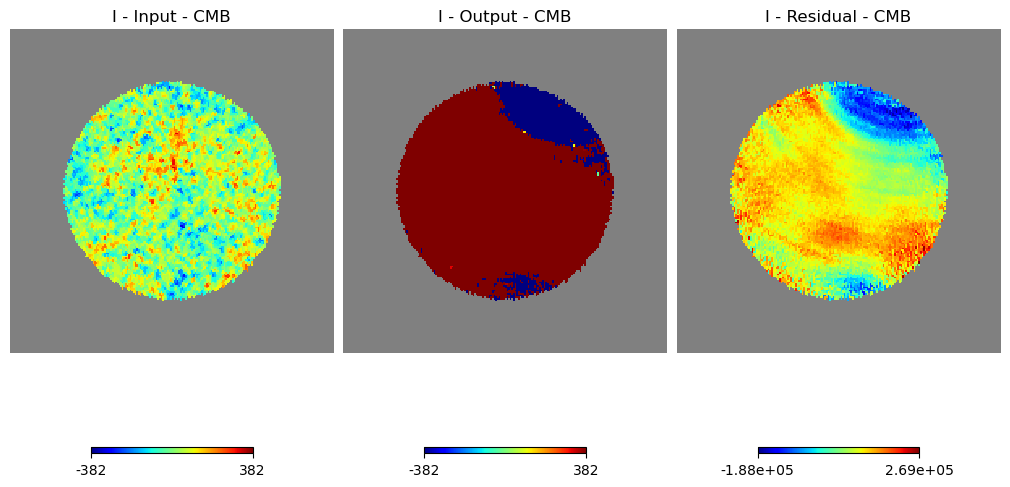

In [33]:
plt.figure(figsize=(10, 12))
k = 1

hp.gnomview(
    input[:, istk],
    reso=reso,
    rot=center_gal,
    min=min_input[0, istk],
    max=max_input[0, istk],
    cmap="jet",
    sub=(1, 3, k),
    title=f"{stk[istk]} - Input - {map}",
    notext=True,
)
hp.gnomview(
    output[:, istk],
    reso=reso,
    rot=center,
    min=min_input[0, istk],
    max=max_input[0, istk],
    cmap="jet",
    sub=(1, 3, k + 1),
    title=f"{stk[istk]} - Output - {map}",
    notext=True,
)
hp.gnomview(
    residual[:, istk],
    reso=reso,
    rot=center,
    cmap="jet",
    sub=(1, 3, k + 2),
    title=f"{stk[istk]} - Residual - {map}",
    notext=True,
)
k += 3

plt.tight_layout()

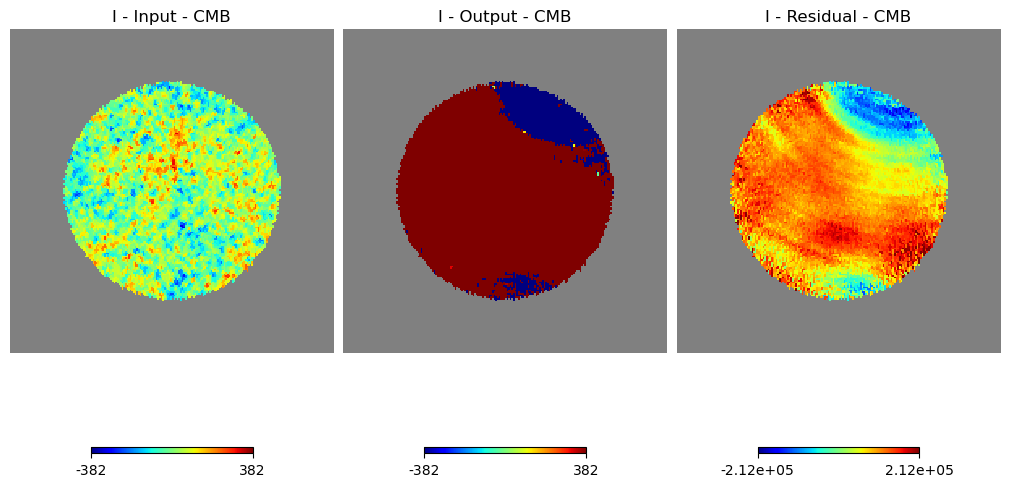

In [34]:
plt.figure(figsize=(10, 12))
k = 1

sigma = np.std(residual[seenpix_gal, istk])
nsigma = 3

hp.gnomview(
    input[:, istk],
    reso=reso,
    rot=center_gal,
    min=min_input[0, istk],
    max=max_input[0, istk],
    cmap="jet",
    sub=(1, 3, k),
    title=f"{stk[istk]} - Input - {map}",
    notext=True,
)
hp.gnomview(
    output[:, istk],
    reso=reso,
    rot=center,
    min=min_input[0, istk],
    max=max_input[0, istk],
    cmap="jet",
    sub=(1, 3, k + 1),
    title=f"{stk[istk]} - Output - {map}",
    notext=True,
)
hp.gnomview(
    residual[:, istk],
    reso=reso,
    rot=center,
    min=-nsigma * sigma,
    max=nsigma * sigma,
    cmap="jet",
    sub=(1, 3, k + 2),
    title=f"{stk[istk]} - Residual - {map}",
    notext=True,
)
k += 3

plt.tight_layout()

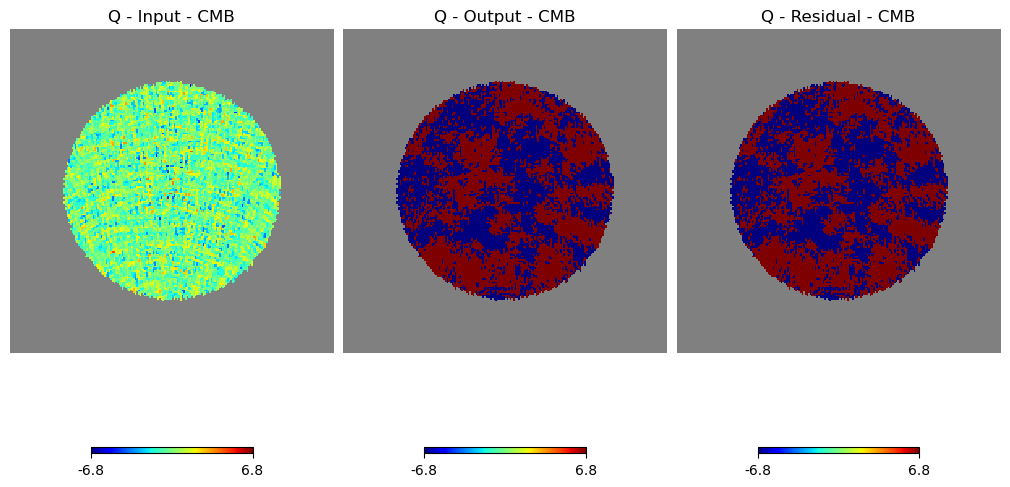

In [35]:
plt.figure(figsize=(10, 12))
k = 1

istk = 1

hp.gnomview(
    input[:, istk],
    reso=reso,
    rot=center_gal,
    min=min_input[0, istk],
    max=max_input[0, istk],
    cmap="jet",
    sub=(1, 3, k),
    title=f"{stk[istk]} - Input - {map}",
    notext=True,
)
hp.gnomview(
    output[:, istk],
    reso=reso,
    rot=center,
    min=min_input[0, istk],
    max=max_input[0, istk],
    cmap="jet",
    sub=(1, 3, k + 1),
    title=f"{stk[istk]} - Output - {map}",
    notext=True,
)
hp.gnomview(
    residual[:, istk],
    reso=reso,
    rot=center,
    min=min_input[0, istk],
    max=max_input[0, istk],
    cmap="jet",
    sub=(1, 3, k + 2),
    title=f"{stk[istk]} - Residual - {map}",
    notext=True,
)
k += 3

plt.tight_layout()

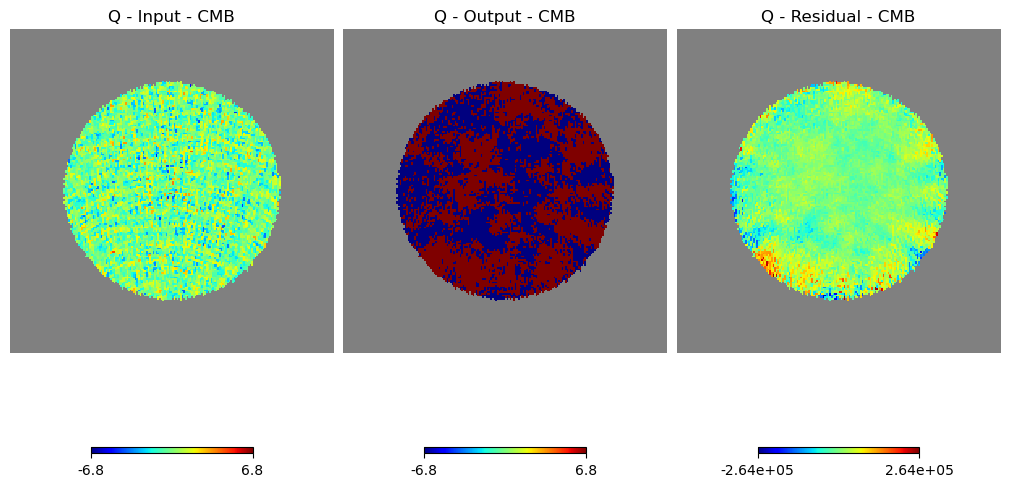

In [36]:
plt.figure(figsize=(10, 12))
k = 1

min_res = np.min(residual[seenpix_gal, istk])
max_res = np.max(residual[seenpix_gal, istk])
range_hp = np.max([-min_res, max_res])


hp.gnomview(
    input[:, istk],
    reso=reso,
    rot=center_gal,
    min=min_input[0, istk],
    max=max_input[0, istk],
    cmap="jet",
    sub=(1, 3, k),
    title=f"{stk[istk]} - Input - {map}",
    notext=True,
)
hp.gnomview(
    output[:, istk],
    reso=reso,
    rot=center,
    min=min_input[0, istk],
    max=max_input[0, istk],
    cmap="jet",
    sub=(1, 3, k + 1),
    title=f"{stk[istk]} - Output - {map}",
    notext=True,
)
hp.gnomview(
    residual[:, istk],
    reso=reso,
    rot=center,
    min=-range_hp,
    max=range_hp,
    cmap="jet",
    sub=(1, 3, k + 2),
    title=f"{stk[istk]} - Residual - {map}",
    notext=True,
)
k += 3

plt.tight_layout()